In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import pandas as pd
from ultralytics import YOLO
from ultralytics.utils import LOGGER

MOCAP_FRAMES = 12000
MOCAP_FRAME_RATE = 100
RGB_FRAME_RATE = 25

total MoCap frames: 12000, MoCap Frame rate: 100.0
Good shot Timestamp: 4 seconds
[MoCap] Right hand peak height frame: 450 (time 4.50 s)


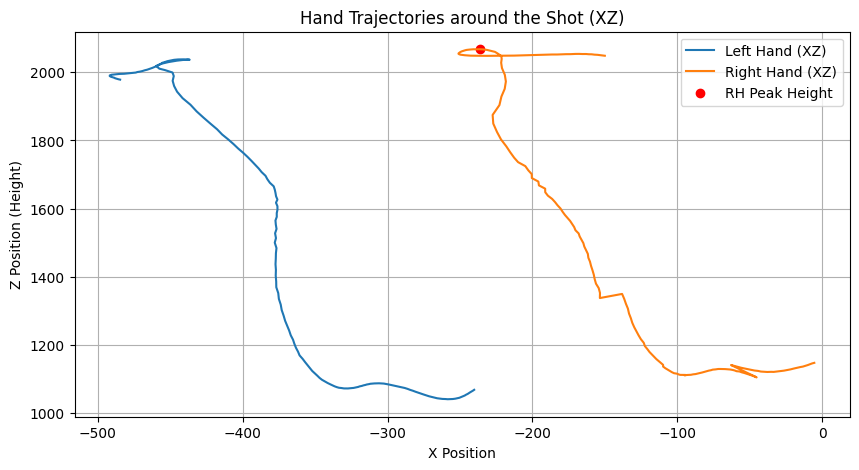

Good shot Timestamp: 8 seconds
[MoCap] Right hand peak height frame: 800 (time 8.00 s)


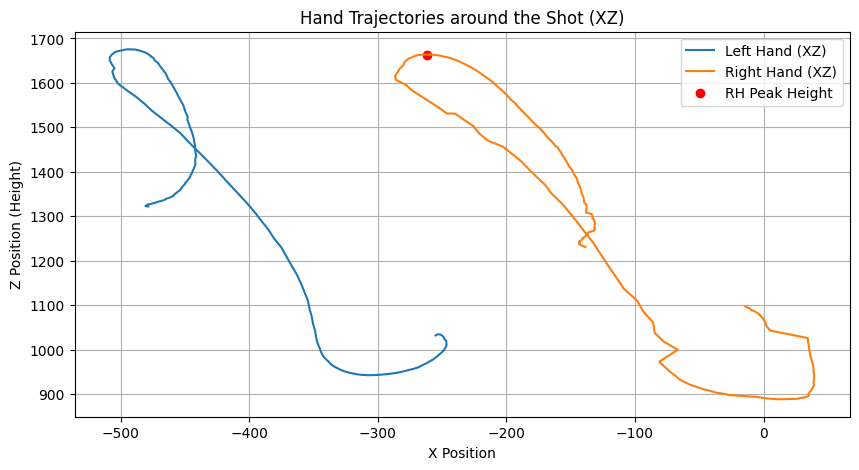

Good shot Timestamp: 17 seconds
[MoCap] Right hand peak height frame: 1725 (time 17.25 s)


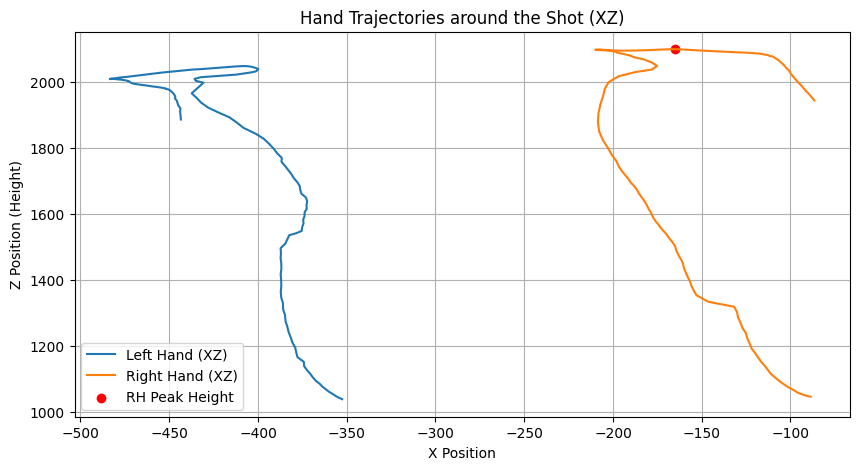

Good shot Timestamp: 20 seconds
[MoCap] Right hand peak height frame: 2015 (time 20.15 s)


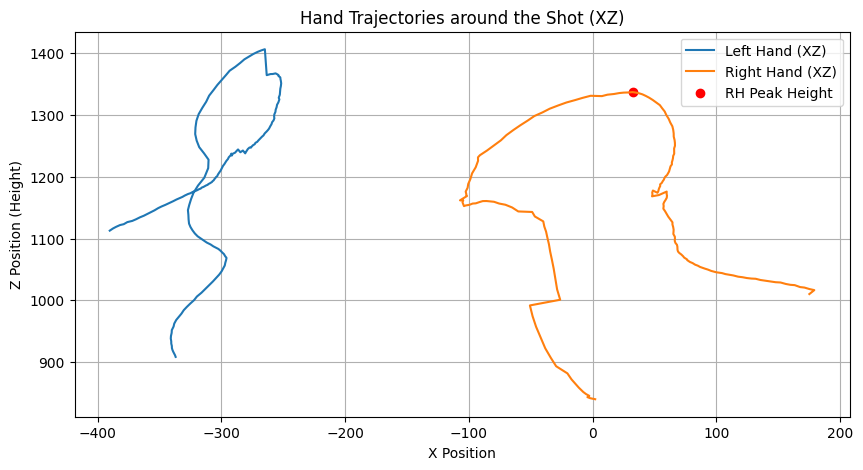

Good shot Timestamp: 23 seconds
[MoCap] Right hand peak height frame: 2296 (time 22.96 s)


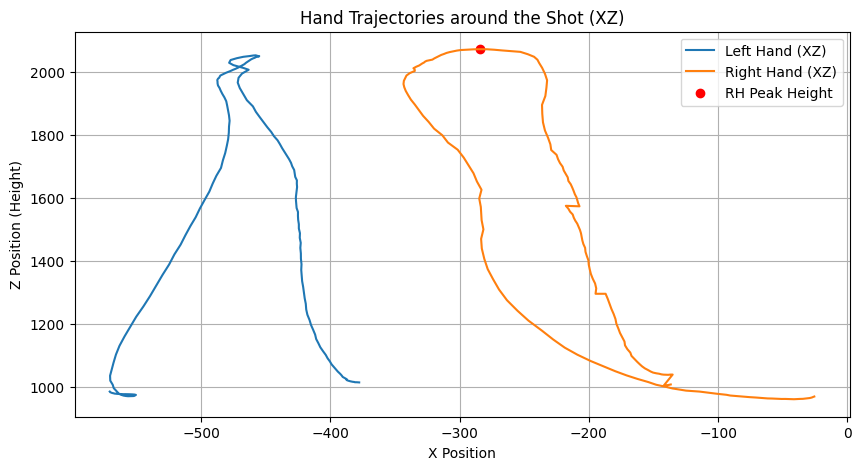

Good shot Timestamp: 26 seconds
[MoCap] Right hand peak height frame: 2630 (time 26.30 s)


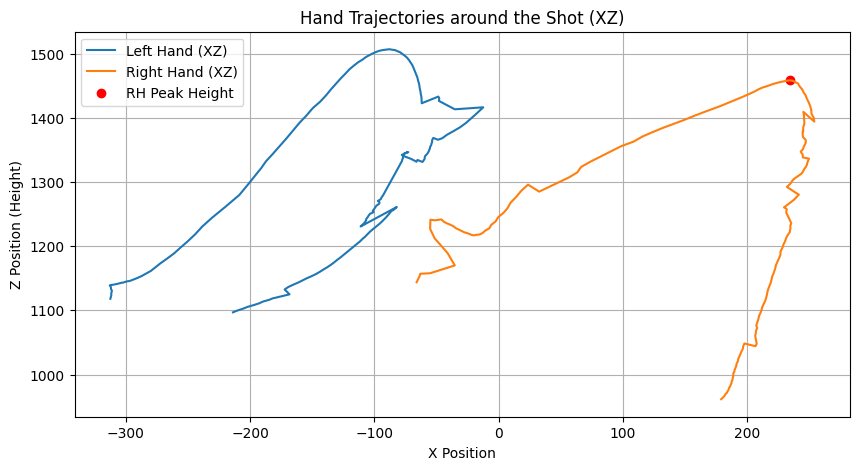

In [2]:
good_shots = [4,8,17,20,23,26] #timestamps given of goodshots, in seconds

# ---- STEP 1: Load MoCap data ----
mat = scipy.io.loadmat('Motion_Capture_Data/Nick_2.mat', struct_as_record=False, squeeze_me=True)
nick = mat['Nick_2']

frame_rate = nick.FrameRate
position_data = nick.Skeletons.PositionData  # (3, 24, n_frames)
segment_labels = [str(label) for label in nick.Skeletons.SegmentLabels]
n_frames = position_data.shape[2]

# Index of the right and left hand
left_hand_idx = segment_labels.index('LeftHand')
right_hand_idx = segment_labels.index('RightHand')

print(f"total MoCap frames: {n_frames}, MoCap Frame rate: {frame_rate}")

def findPeak():
    # Suppose the known good shot timestamp from MoCap is 4s
    good_shot_time_mocap = gs
    good_shot_frame_idx = int(good_shot_time_mocap * frame_rate)

    # Define window around shot (1s before/after)
    window = int(1*frame_rate)
    start_idx = max(0, good_shot_frame_idx - window)
    end_idx = min(n_frames, good_shot_frame_idx + window)

    # Get left and right hand positions
    left_hand_traj = position_data[:, left_hand_idx, start_idx:end_idx]
    right_hand_traj = position_data[:, right_hand_idx, start_idx:end_idx]

    # Find peak Z (height) of right hand
    z_traj = right_hand_traj[2, :]
    peak_relative_frame = np.argmax(z_traj)
    peak_absolute_frame = start_idx + peak_relative_frame
    peak_time_mocap = peak_absolute_frame / frame_rate

    print(f"Good shot Timestamp: {gs} seconds")
    print(f"[MoCap] Right hand peak height frame: {peak_absolute_frame} (time {peak_time_mocap:.2f} s)")

    # Plot 2D XZ trajectories
    plt.figure(figsize=(10, 5))
    plt.plot(left_hand_traj[0, :], left_hand_traj[2, :], label='Left Hand (XZ)')
    plt.plot(right_hand_traj[0, :], right_hand_traj[2, :], label='Right Hand (XZ)')
    plt.scatter(right_hand_traj[0, peak_relative_frame], right_hand_traj[2, peak_relative_frame], 
                color='r', label='RH Peak Height')
    plt.xlabel('X Position')
    plt.ylabel('Z Position (Height)')
    plt.title('Hand Trajectories around the Shot (XZ)')
    plt.grid()
    plt.legend()
    plt.show()


for gs in good_shots:
    findPeak()

Good shot Timestamp: 4.000 seconds (Frame 400)


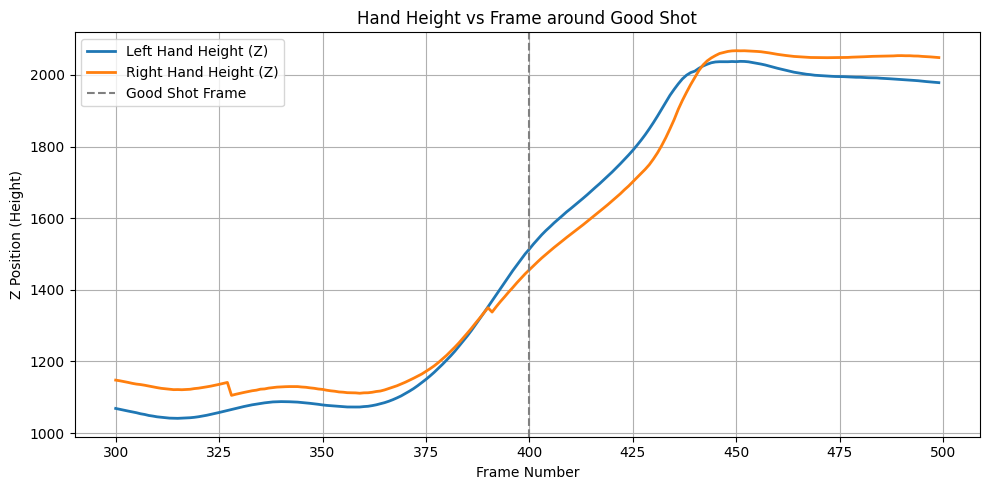

Good shot Timestamp: 8.000 seconds (Frame 800)


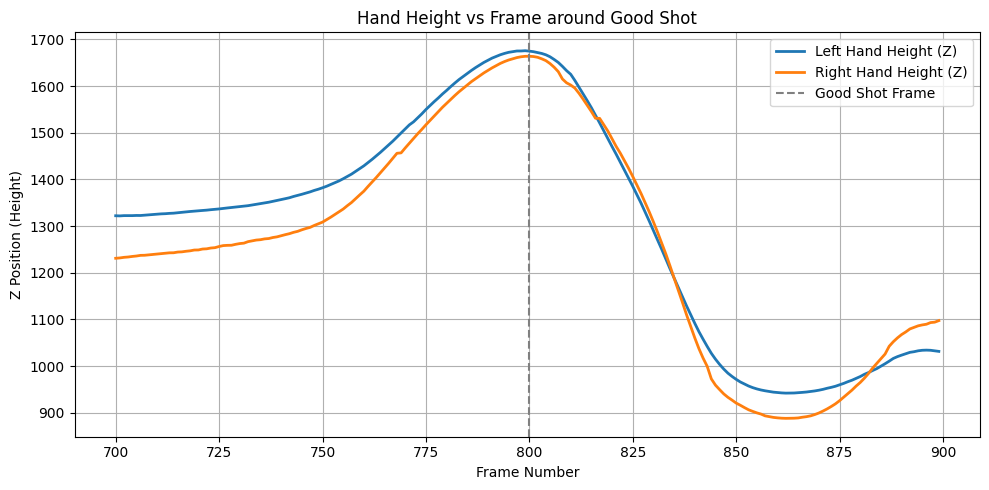

Good shot Timestamp: 17.000 seconds (Frame 1700)


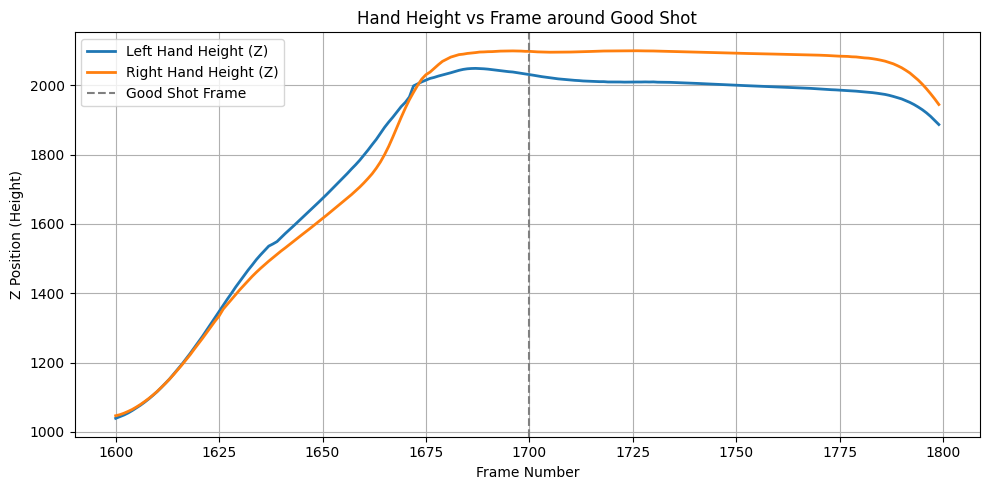

Good shot Timestamp: 20.000 seconds (Frame 2000)


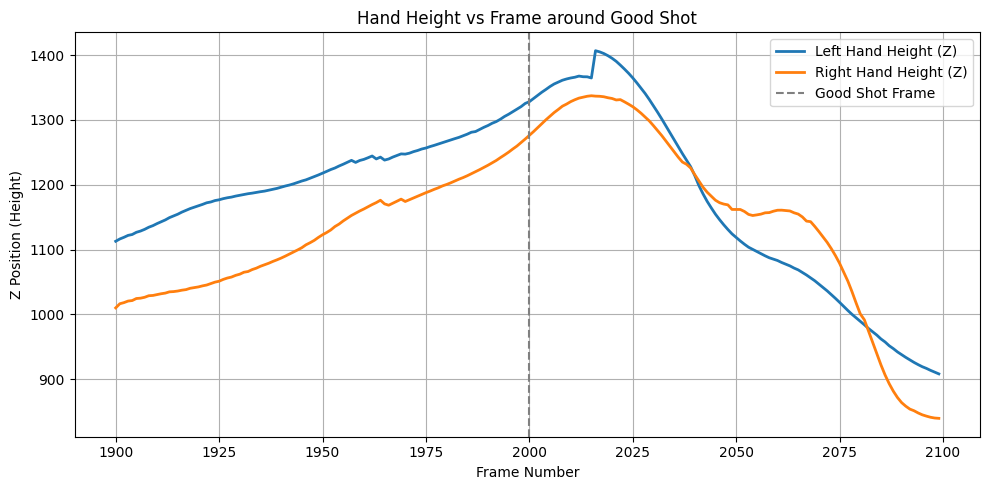

Good shot Timestamp: 23.000 seconds (Frame 2300)


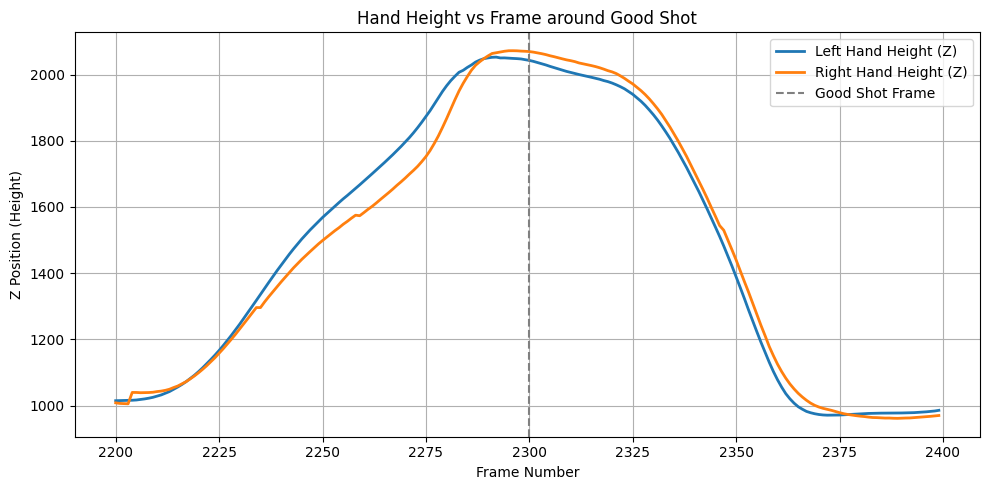

Good shot Timestamp: 26.000 seconds (Frame 2600)


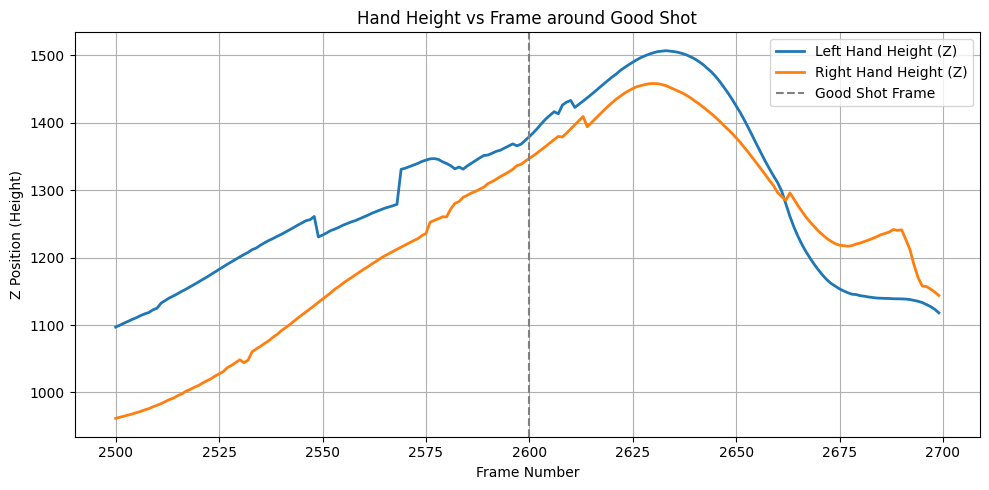

In [8]:
window = 1 #tempo da includere nel plot prima e dopo il timestamp dato
def plotHeight(position_data, segment_labels, frame_rate, good_shot_time_s, window_s):
    """
    Plot Z (height) of both hands over a time window centered at the given good_shot_time.
    
    Parameters:
    - position_data: ndarray of shape (3, 24, N) with XYZ positions of segments over time
    - segment_labels: list of segment label strings, e.g. ['Hips', 'Spine', ..., 'RightHand']
    - frame_rate: frames per second of the MoCap data
    - good_shot_time_s: known timestamp (in seconds) of a good shot
    - window_s: time (in seconds) before and after the timestamp to include in the plot
    """
    n_frames = position_data.shape[2]
    
    # Get hand indices
    left_hand_idx = segment_labels.index('LeftHand')
    right_hand_idx = segment_labels.index('RightHand')
    
    # Convert to frame index
    center_frame = int(good_shot_time_s * frame_rate)
    window = int(window_s * frame_rate)
    start = max(0, center_frame - window)
    end = min(n_frames, center_frame + window)

    # Time x-axis in frames relative to the center
    x = np.arange(start, end) - center_frame

    # Z trajectories
    left_z = position_data[2, left_hand_idx, start:end]
    right_z = position_data[2, right_hand_idx, start:end]

    print(f"Good shot Timestamp: {gs} seconds")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(x, left_z, label='Left Hand Height (Z)', linewidth=2)
    plt.plot(x, right_z, label='Right Hand Height (Z)', linewidth=2)
    plt.axvline(0, color='gray', linestyle='--', label='Good Shot Timestamp')
    plt.xlabel('Frame (relative to good shot)')
    plt.ylabel('Z Position (Height)')
    plt.title('Hand Height vs Frame around Good Shot')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

def plotHeight1(position_data, segment_labels, frame_rate, good_shot_time_s, window_s):
    """
    Plot Z (height) of both hands over a time window centered at the given good_shot_time.
    """
    n_frames = position_data.shape[2]

    # Get hand indices
    left_hand_idx = segment_labels.index('LeftHand')
    right_hand_idx = segment_labels.index('RightHand')

    # Convert to frame index
    center_frame = int(good_shot_time_s * frame_rate)
    window = int(window_s * frame_rate)
    start = max(0, center_frame - window)
    end = min(n_frames, center_frame + window)

    # Time x-axis in actual frame numbers
    x = np.arange(start, end)

    # Z trajectories
    left_z = position_data[2, left_hand_idx, start:end]
    right_z = position_data[2, right_hand_idx, start:end]

    print(f"Good shot Timestamp: {good_shot_time_s:.3f} seconds (Frame {center_frame})")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(x, left_z, label='Left Hand Height (Z)', linewidth=2)
    plt.plot(x, right_z, label='Right Hand Height (Z)', linewidth=2)
    plt.axvline(center_frame, color='gray', linestyle='--', label='Good Shot Frame')
    plt.xlabel('Frame Number')
    plt.ylabel('Z Position (Height)')
    plt.title('Hand Height vs Frame around Good Shot')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for gs in good_shots:
    plotHeight1(position_data=nick.Skeletons.PositionData,
            segment_labels=[str(lbl) for lbl in nick.Skeletons.SegmentLabels],
            frame_rate=nick.FrameRate,
            good_shot_time_s=gs,  # replace with timestamp
            window_s=window)


Saved right arm keypoints to CSV.


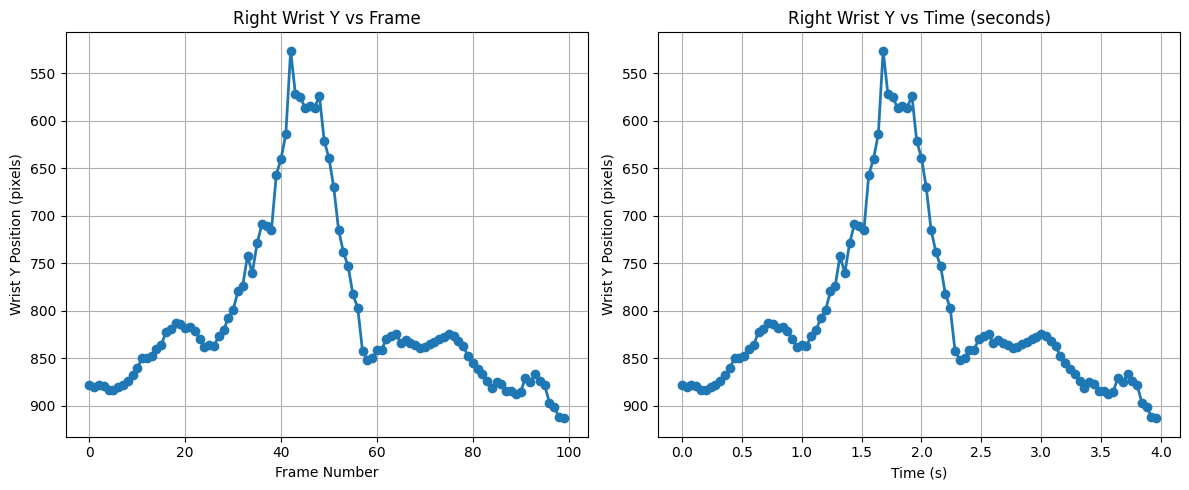

Max wrist height: 526.55 pixels
At frame: 42, which is 1.68 seconds
Frame 42 saved as MaxWristHeight_Frame.png


In [ ]:
fn = []

def get_trajectory_yolo():

    LOGGER.setLevel("WARNING")  # or ERROR to suppress even more
    # Load the YOLOv8-pose model
    model = YOLO("utils/yolov8n-pose.pt")  # or yolov8s-pose.pt


    # Load your video
    video_path = "resources/out2.mp4"
    cap = cv2.VideoCapture(video_path)

    # Store keypoints over time
    frame_data = []

    cv2.namedWindow("Tracking", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Tracking", 960, 540)

    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_width = frame.shape[1]
        midpoint = frame_width // 2

        # Run pose estimation
        results = model(frame, conf=0.3)[0]

        # Get all detections
        people = results.keypoints.xy  # list of tensors [num_people, num_kpts, 2]

        rightmost_person = None
        max_x = -1

        for p in people:
            # Compute person's center x position based on average x of shoulder keypoints (5 and 6)
            kp = p.cpu().numpy()  # shape (17, 2)
            if kp.shape[0] < 11:  # skip incomplete detections
                continue

            person_x_center = (kp[5][0] + kp[6][0]) / 2  # avg of left/right shoulder

            # Only consider person whose center is on the right half
            if person_x_center > midpoint and person_x_center > max_x:
                rightmost_person = kp
                max_x = person_x_center

        # If a person on the right was found, extract keypoints
        if rightmost_person is not None:
            right_shoulder = rightmost_person[6]
            right_elbow = rightmost_person[8]
            right_wrist = rightmost_person[10]

            # Save the keypoints
            frame_data.append({
                "frame": frame_idx,
                "right_shoulder_x": right_shoulder[0],
                "right_shoulder_y": right_shoulder[1],
                "right_elbow_x": right_elbow[0],
                "right_elbow_y": right_elbow[1],
                "right_wrist_x": right_wrist[0],
                "right_wrist_y": right_wrist[1],
            })

            # Optional: draw skeleton
            for i, point in enumerate([right_shoulder, right_elbow, right_wrist]):
                x, y = int(point[0]), int(point[1])
                cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)

            cv2.line(frame, tuple(right_shoulder.astype(int)), tuple(right_elbow.astype(int)), (255, 0, 0), 2)
            cv2.line(frame, tuple(right_elbow.astype(int)), tuple(right_wrist.astype(int)), (255, 0, 0), 2)

        # Display
        cv2.imshow("Tracking", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

        frame_idx += 1

    cap.release()
    cv2.destroyAllWindows()

    # Save data to CSV
    df = pd.DataFrame(frame_data)
    df.to_csv("right_arm_keypoints.csv", index=False)
    print("Saved right arm keypoints to CSV.")

def plot_keypoint_data():
    global fn

    # Load keypoint data
    df = pd.read_csv("right_arm_keypoints.csv")

    # Extract relevant columns
    frames = df["frame"]
    wrist_y = df["right_wrist_y"]

    min_y_index = wrist_y.idxmin()
    frame_number = df.loc[min_y_index, "frame"]
    fn = frame_number
    wrist_y_value = df.loc[min_y_index, "right_wrist_y"]
    timestamp_seconds = frame_number / RGB_FRAME_RATE
    time_seconds = frames / RGB_FRAME_RATE
    # --- Plot vs Frame ---
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(frames, wrist_y, marker='o', linewidth=2)
    plt.title("Right Wrist Y vs Frame")
    plt.xlabel("Frame Number")
    plt.ylabel("Wrist Y Position (pixels)")
    plt.gca().invert_yaxis()
    plt.grid(True)

    # --- Plot vs Time ---
    plt.subplot(1, 2, 2)
    plt.plot(time_seconds, wrist_y, marker='o', linewidth=2)
    plt.title("Right Wrist Y vs Time (seconds)")
    plt.xlabel("Time (s)")
    plt.ylabel("Wrist Y Position (pixels)")
    plt.gca().invert_yaxis()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Max wrist height: {wrist_y_value:.2f} pixels")
    print(f"At frame: {frame_number}, which is {timestamp_seconds:.2f} seconds")

def save_frame_from_video(frame_number):
    # Open the video
    video_path = "resources/out2.mp4"
    output_path = "MaxWristHeight_Frame.png"
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    success, frame = cap.read()

    if success:
        # Save the frame as an image
        cv2.imwrite(output_path, frame)
        print(f"Frame {frame_number} saved as {output_path}")
    else:
        print(f"Error: Could not read frame {frame_number}.")

    cap.release()


get_trajectory_yolo()
plot_keypoint_data()
save_frame_from_video(fn)